# Exploring Neuropixels Recordings from Mouse Hippocampus During Odor Presentation

**Note: This notebook was auto-generated using dandi-notebook-gen and should be carefully validated before use.**

This notebook demonstrates how to access and analyze neural recordings from head-fixed mice during odor presentation experiments. The data was collected using Neuropixels probes in the hippocampus.

## Required Packages

Before running this notebook, ensure you have the following packages installed:
- pynwb
- lindi
- numpy
- matplotlib
- seaborn

In [1]:
import pynwb
import lindi
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the plotting style
sns.set_theme()

## Loading the Dataset

First, we'll use the DANDI API to get information about the dataset and its contents.

In [2]:
from dandi.dandiapi import DandiAPIClient

client = DandiAPIClient()
dandiset = client.get_dandiset("001335")
assets = list(dandiset.get_assets())
print(f"Number of NWB files in dataset: {len(assets)}")
for asset in assets:
    print(f"\nFile: {asset.path}")
    print(f"Size: {asset.size / 1e6:.1f} MB")

Number of NWB files in dataset: 1

File: sub-M541/sub-M541_ecephys.nwb
Size: 1374.3 MB


## Loading and Exploring the NWB File

Let's load the NWB file and examine its contents. This dataset contains recordings from a mouse hippocampus during presentation of different odors.

In [3]:
# Load the NWB file
f = lindi.LindiH5pyFile.from_lindi_file("https://lindi.neurosift.org/dandi/dandisets/001335/assets/aca66db7-4c02-4453-8dcb-a179d44b1c5d/nwb.lindi.json")
nwb = pynwb.NWBHDF5IO(file=f, mode='r').read()

# Print basic session information
print("Session Information:")
print(f"Description: {nwb.session_description}")
print(f"Subject ID: {nwb.subject.subject_id}")
print(f"Age: {nwb.subject.age}")
print(f"Sex: {nwb.subject.sex}")
print(f"Species: {nwb.subject.species}")
print("\nExperimental Details:")
print(f"Experimenter: {nwb.experimenter}")
print(f"Lab: {nwb.lab}")
print(f"Institution: {nwb.institution}")

Session Information:
Description: Block 1:UE (ABC), Block 2:SE (DEF), Block3:Localizer
Subject ID: M541
Age: P8W/
Sex: M
Species: Mus musculus

Experimental Details:
Experimenter: ('Mohapatra, Manish',)
Lab: vandermeerlab
Institution: Dartmouth College


## Understanding the Recording Setup

The neural activity was recorded using a Neuropixels probe. Let's examine the electrode configuration and recording details.

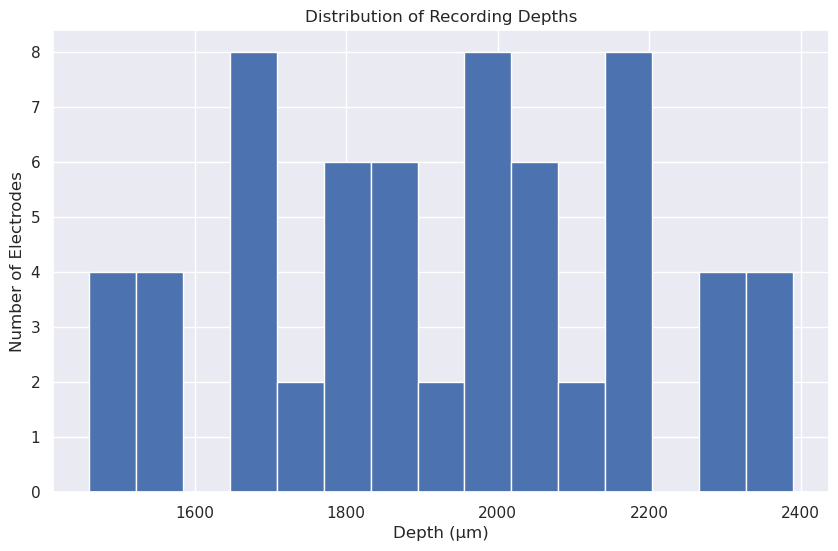


Recording Details:
Number of electrodes: 64
Depth range: 1460 to 2390 μm
Number of units: 283
LFP sampling rate: 2500.0 Hz


In [4]:
# Get electrode information
electrodes = nwb.electrodes
electrode_depths = electrodes['depth'].data[:]

# Plot electrode depth distribution
plt.figure(figsize=(10, 6))
plt.hist(electrode_depths, bins=15)
plt.xlabel('Depth (μm)')
plt.ylabel('Number of Electrodes')
plt.title('Distribution of Recording Depths')
plt.grid(True)
plt.show()

print("\nRecording Details:")
print(f"Number of electrodes: {len(electrode_depths)}")
print(f"Depth range: {electrode_depths.min():.0f} to {electrode_depths.max():.0f} μm")
print(f"Number of units: {len(nwb.units['id'].data)}")
print(f"LFP sampling rate: {nwb.processing['ecephys']['LFP'].rate} Hz")

## Experimental Structure: Odor Presentations

The experiment consists of three blocks with different odor presentations. Let's examine the timing and structure of these presentations.

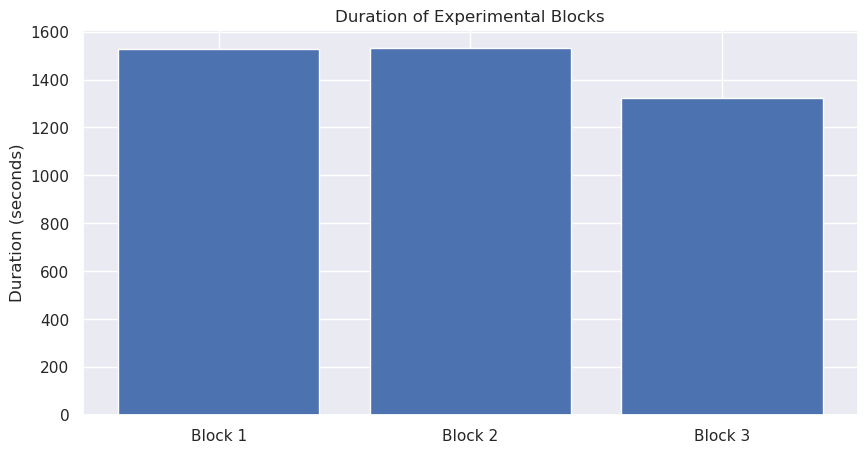


Odor Presentation Statistics:

Odor A:
Number of presentations: 101
Average duration: 2.00 seconds

Odor B:
Number of presentations: 101
Average duration: 2.00 seconds

Odor C:
Number of presentations: 101
Average duration: 2.00 seconds

Odor D:
Number of presentations: 101
Average duration: 2.00 seconds

Odor E:
Number of presentations: 101
Average duration: 2.00 seconds

Odor F:
Number of presentations: 101
Average duration: 2.00 seconds


In [5]:
# Get block timings
blocks = ['Block 1', 'Block 2', 'Block 3']
block_starts = []
block_durations = []

for block in blocks:
    interval = nwb.intervals[block]
    start = interval['start_time'][0]
    stop = interval['stop_time'][0]
    block_starts.append(start)
    block_durations.append(stop - start)

# Plot block durations
plt.figure(figsize=(10, 5))
plt.bar(blocks, block_durations)
plt.title('Duration of Experimental Blocks')
plt.ylabel('Duration (seconds)')
plt.grid(True)
plt.show()

# Get odor presentation statistics
odors = ['A', 'B', 'C', 'D', 'E', 'F']
print("\nOdor Presentation Statistics:")
for odor in odors:
    interval = nwb.intervals[f'Odor {odor} ON']
    n_presentations = len(interval['start_time'])
    mean_duration = np.mean(interval['stop_time'][:] - interval['start_time'][:])
    print(f"\nOdor {odor}:")
    print(f"Number of presentations: {n_presentations}")
    print(f"Average duration: {mean_duration:.2f} seconds")

## Accessing Neural Data

The dataset includes both Local Field Potential (LFP) recordings and sorted spike data. Let's look at how to access and visualize these different types of neural signals.

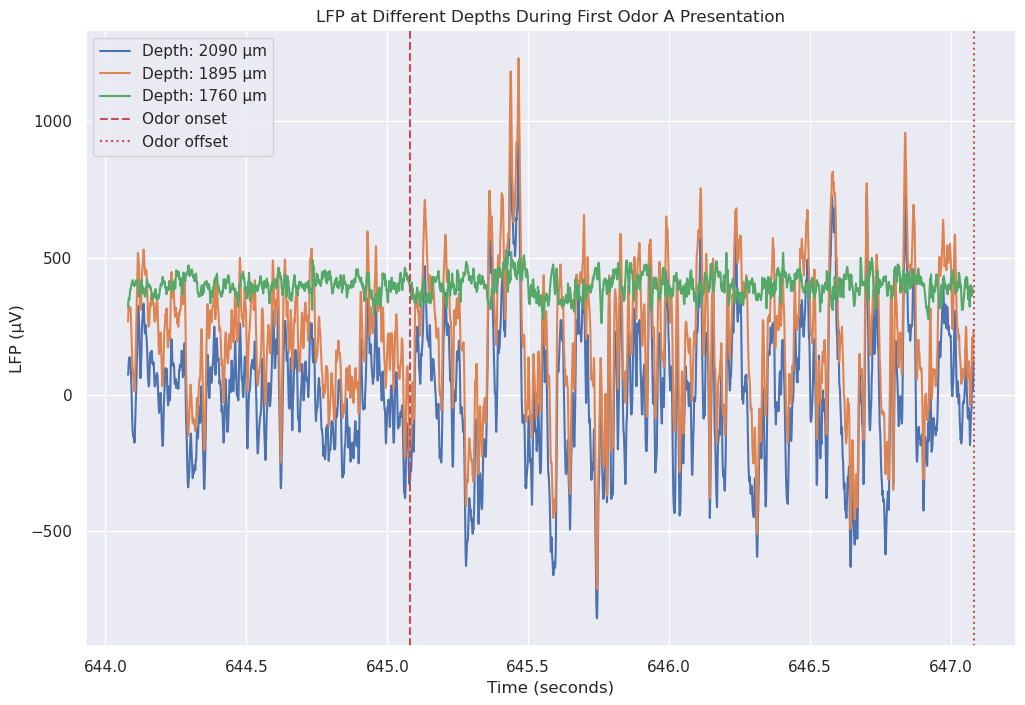

In [6]:
# Get LFP data for a short window during the first odor presentation
lfp = nwb.processing['ecephys']['LFP']
sampling_rate = lfp.rate

# Choose 3 channels at different depths
depth_percentiles = [25, 50, 75]
channel_indices = []
for p in depth_percentiles:
    target_depth = np.percentile(electrode_depths, p)
    idx = np.argmin(np.abs(electrode_depths - target_depth))
    channel_indices.append(idx)
channel_indices = sorted(list(set(channel_indices)))

# Get timing for first odor A presentation
odor_A_interval = nwb.intervals['Odor A ON']
start_time = odor_A_interval['start_time'][0]

# Get data window (1s before to 2s after odor onset)
window_start = int((start_time - 1) * sampling_rate)
window_end = int((start_time + 2) * sampling_rate)
time = np.arange(window_start, window_end) / sampling_rate

# Get LFP data
lfp_data = lfp.data[window_start:window_end, channel_indices]

# Plot LFP traces
plt.figure(figsize=(12, 8))
for i, (data, idx) in enumerate(zip(lfp_data.T, channel_indices)):
    depth = electrode_depths[idx]
    plt.plot(time, data + i*200, label=f'Depth: {depth:.0f} μm')

plt.axvline(x=start_time, color='r', linestyle='--', label='Odor onset')
plt.axvline(x=odor_A_interval['stop_time'][0], color='r', linestyle=':', label='Odor offset')
plt.xlabel('Time (seconds)')
plt.ylabel('LFP (μV)')
plt.title('LFP at Different Depths During First Odor A Presentation')
plt.legend()
plt.grid(True)
plt.show()

## Working with Spike Data

The dataset includes sorted spike data from 283 units. Here's how to access and work with this data:

Total number of units: 283

Unit depth range: 1460.0 to 2330.0 μm


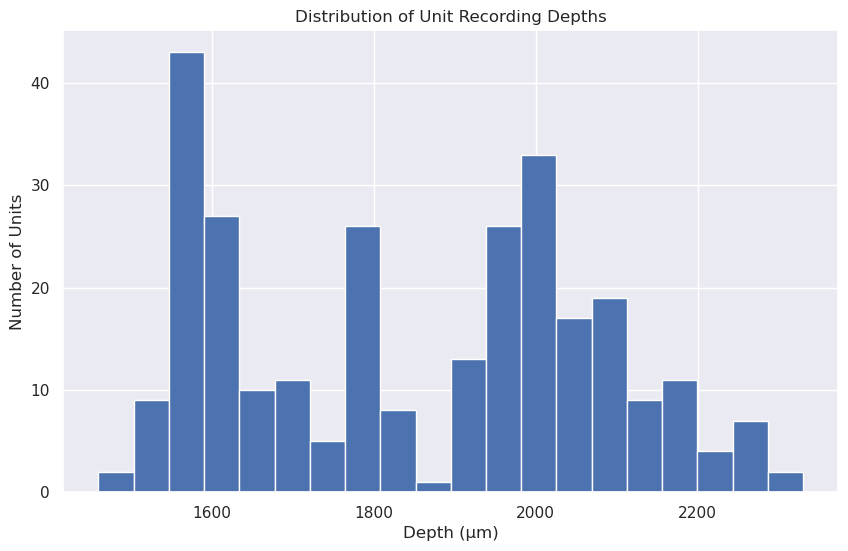

In [7]:
# Get basic information about the units
units = nwb.units
unit_depths = units['depth'][:]
unit_hemispheres = units['hemisphere'][:]

print(f"Total number of units: {len(unit_depths)}")
print(f"\nUnit depth range: {np.min(unit_depths):.1f} to {np.max(unit_depths):.1f} μm")

# Plot unit depth distribution
plt.figure(figsize=(10, 6))
plt.hist(unit_depths, bins=20)
plt.xlabel('Depth (μm)')
plt.ylabel('Number of Units')
plt.title('Distribution of Unit Recording Depths')
plt.grid(True)
plt.show()

## Next Steps

This notebook demonstrates the basic structure of the dataset and how to access its different components. Here are some suggested analyses you might want to perform:

1. Compare LFP patterns between different odors
2. Analyze spike rate changes during odor presentations
3. Look for depth-dependent differences in neural responses
4. Examine trial-to-trial variability in responses

Remember that when working with the data:
- The LFP data is sampled at 2500 Hz and filtered between 1-400 Hz
- Each odor presentation lasts approximately 2 seconds
- The experiment is divided into three blocks with different odor sequences
- Consider loading subsets of the data when working with the full dataset, as the files are hosted remotely